# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [15]:
from sklearn.datasets import fetch_20newsgroups # type: ignore
import sys

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

print("Number of documents:", len(newsgroupsdocs))
print("Primer documento len:", len(newsgroupsdocs[0]))
print("Tamaño de la lista:", sys.getsizeof(newsgroupsdocs), "bytes")

Number of documents: 18846
Primer documento len: 712
Tamaño de la lista: 150824 bytes


## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Utiliza el corpus cargado (newsgroupsdocs)
# Puedes probar con una muestra más pequeña si es necesario
# newsgroupsdocs = newsgroupsdocs[:1000]

# 2. Construye la matriz de términos (TF-IDF)
vectorizer = TfidfVectorizer(use_idf=True, norm=None)  # norm=None para ver los valores reales de TF e IDF
X_tfidf = vectorizer.fit_transform(newsgroupsdocs)

# 3. Extrae el vocabulario
vocabulario = vectorizer.get_feature_names_out()

# 4. Calcula DF e IDF
df = (X_tfidf > 0).sum(axis=0).A1  # Document Frequency
idf = vectorizer.idf_  # IDF de sklearn

# 5. Obtén TF-IDF del documento 0 sin convertir toda la matriz
doc_0_sparse = X_tfidf[0]  # Matriz dispersa para el doc 0
indices = doc_0_sparse.indices
data = doc_0_sparse.data

# 6. Construye el DataFrame solo con los términos del documento 0
df_doc0 = pd.DataFrame({
    'Término': vocabulario[indices],
    'TF-IDF (doc 0)': data,
    'DF': df[indices],
    'IDF': idf[indices]
})

# 7. Ordena por los términos con mayor TF-IDF en el documento 0
df_doc0 = df_doc0.sort_values(by='TF-IDF (doc 0)', ascending=False)

# 8. Muestra los primeros términos relevantes
print(df_doc0.head(10))


          Término  TF-IDF (doc 0)     DF       IDF
51           pens       32.437001     77  6.487400
34           jagr       14.820244     30  7.410122
16         devils       12.899320     80  6.449660
74            the       11.795134  15749  1.179513
12            bit       11.637086   1058  3.879029
49             of       11.089021  12809  1.386128
23            fun       11.081608    200  5.540804
61        regular       10.702095    242  5.351048
65         season       10.247595    304  5.123797
52  pittsburghers        9.745497      2  9.745497


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# 3. Definir una consulta (se puede cambiar)
consulta = ["space"]

# 4. Vectorizar la consulta usando el mismo vectorizador entrenado
consulta_tfidf = vectorizer.transform(consulta)

# 5. Calcular la similitud coseno entre la consulta y todos los documentos
similitudes = cosine_similarity(consulta_tfidf, X_tfidf).flatten()

# 6. Obtener el ranking (índices de documentos más relevantes)
ranking_indices = similitudes.argsort()[::-1]

# 7. Mostrar el top N resultado
top_n = 5
resultados = pd.DataFrame({
    'Indice Documento': ranking_indices[:top_n],
    'Similitud': similitudes[ranking_indices[:top_n]],
    'Contenido': [newsgroupsdocs[i][:25] + "..." for i in ranking_indices[:top_n]]  # Mostrar solo los primeros 200 caracteres
})


# Mostrar la tabla
print(resultados)

# Obtener el índice del documento con mayor similitud
indice_mayor_similitud = ranking_indices[0]

# Imprimir el contenido del documento con mayor similitud
print("Documento con mayor similitud:", indice_mayor_similitud)
print("Similitud total:", similitudes[indice_mayor_similitud])

   Indice Documento  Similitud                      Contenido
0             10867   0.580539   Archive-name: space/group...
1             15147   0.561542   There is an interesting o...
2             10571   0.509317  Archive-name: space/net\nL...
3              2826   0.444225   [A lot of this article ha...
4             12888   0.423766   This notice will be poste...
Documento con mayor similitud: 10867
Similitud total: 0.5805389673139816


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [18]:
!pip install rank_bm25


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from rank_bm25 import BM25Okapi
import numpy as np
import pandas as pd

# 1. Prepara el corpus tokenizado para BM25
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]

# 2. Crea el modelo BM25
bm25 = BM25Okapi(tokenized_corpus)

# 3. Definir o verificar la consulta
# Por ejemplo:
# consulta = "space mission launch"   # si no está definida

# Validación: asegurarse de que consulta es string
if consulta is None:
    raise ValueError("La variable 'consulta' no está definida.")

if isinstance(consulta, list):
    consulta = " ".join(consulta)  # convertir lista a string

if not isinstance(consulta, str):
    raise TypeError("La variable 'consulta' debe ser una cadena de texto o lista de palabras.")

# 4. Tokeniza la consulta
consulta_bm25 = consulta.lower().split()

# 5. Calcula los scores BM25 para cada documento
bm25_scores = bm25.get_scores(consulta_bm25)

# 6. Genera el ranking de los documentos ordenados por relevancia
ranking_bm25 = np.argsort(bm25_scores)[::-1]
top_n = 10

# 7. Muestra los resultados en una tabla
resultados_bm25 = pd.DataFrame({
    'Documento': ranking_bm25[:top_n],
    'Score': [bm25_scores[i] for i in ranking_bm25[:top_n]],
    'Texto': [newsgroupsdocs[i][:200] + "..." for i in ranking_bm25[:top_n]]
})

# 8. Muestra los resultados ordenados
print(resultados_bm25)


   Documento     Score                                              Texto
0      15147  7.763424  There is an interesting opinion piece in the b...
1      10867  7.697895  Archive-name: space/groups\nLast-modified: $Da...
2      14293  7.545986  We are not at the end of the Space Age, but on...
3      15083  7.358824  Archive-name: space/addresses\nLast-modified: ...
4      18182  7.288839  I'm replying to someone who asked for informat...
5        610  7.285465  To All -- I thought the net would find this am...
6       8330  7.168685  \nIf raw materials where to cost enough that g...
7       5749  7.151472  \nat least be honest.  velcro (tm) dates from ...
8        453  7.063588  : >Why not build a inflatable space dock.\n\n:...
9      10571  7.030645  Archive-name: space/net\nLast-modified: $Date:...


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

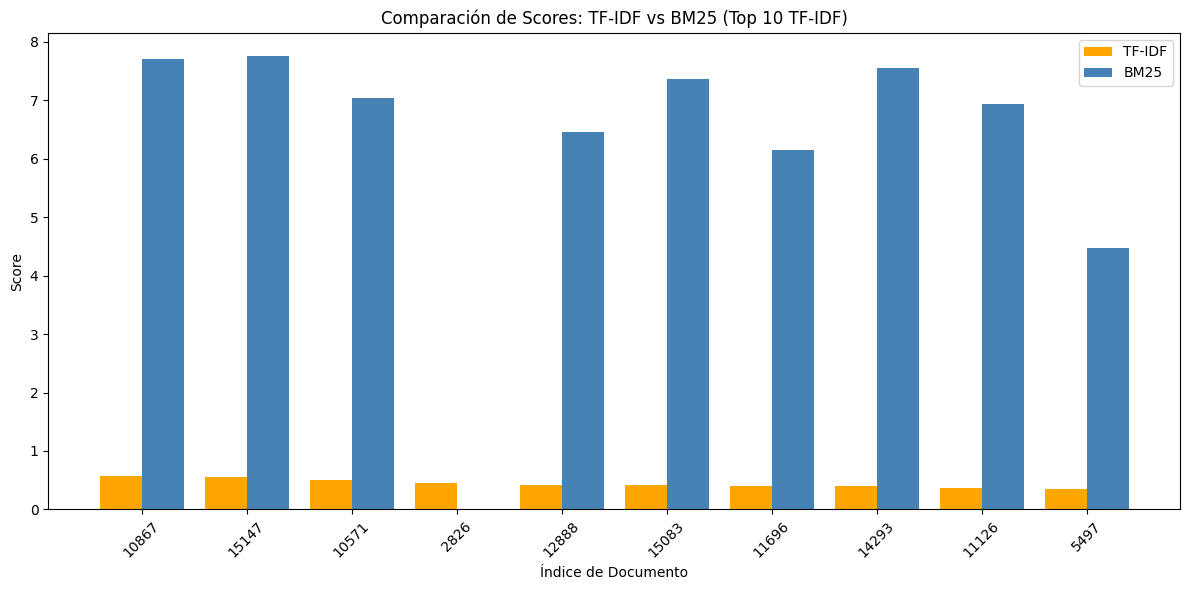

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# Selecciona los mismos documentos top_n para ambos modelos (por ejemplo, los top 10 de TF-IDF)
top_n = 10
top_tfidf_indices = ranking_indices[:top_n]

# Prepara los datos para el gráfico
tfidf_scores_top = similitudes[top_tfidf_indices]
bm25_scores_top = bm25_scores[top_tfidf_indices]  # BM25 para los mismos docs que top TF-IDF

# Gráfico de barras comparativo
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), tfidf_scores_top, width=0.4, label='TF-IDF', align='center', color='orange')
plt.bar([i + 0.4 for i in range(top_n)], bm25_scores_top, width=0.4, label='BM25', align='center', color='steelblue')
plt.xticks([i + 0.2 for i in range(top_n)], top_tfidf_indices, rotation=45)
plt.xlabel('Índice de Documento')
plt.ylabel('Score')
plt.title('Comparación de Scores: TF-IDF vs BM25 (Top 10 TF-IDF)')
plt.legend()
plt.tight_layout()
plt.show()


## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?


📊 Evaluación de modelos para la consulta: space shuttle
Documentos relevantes definidos manualmente: {420, 135, 40, 123, 987}
🔹 BM25    - Precision@3: 0.000, MAP: 0.000
🔸 TF-IDF  - Precision@3: 0.000, MAP: 0.000


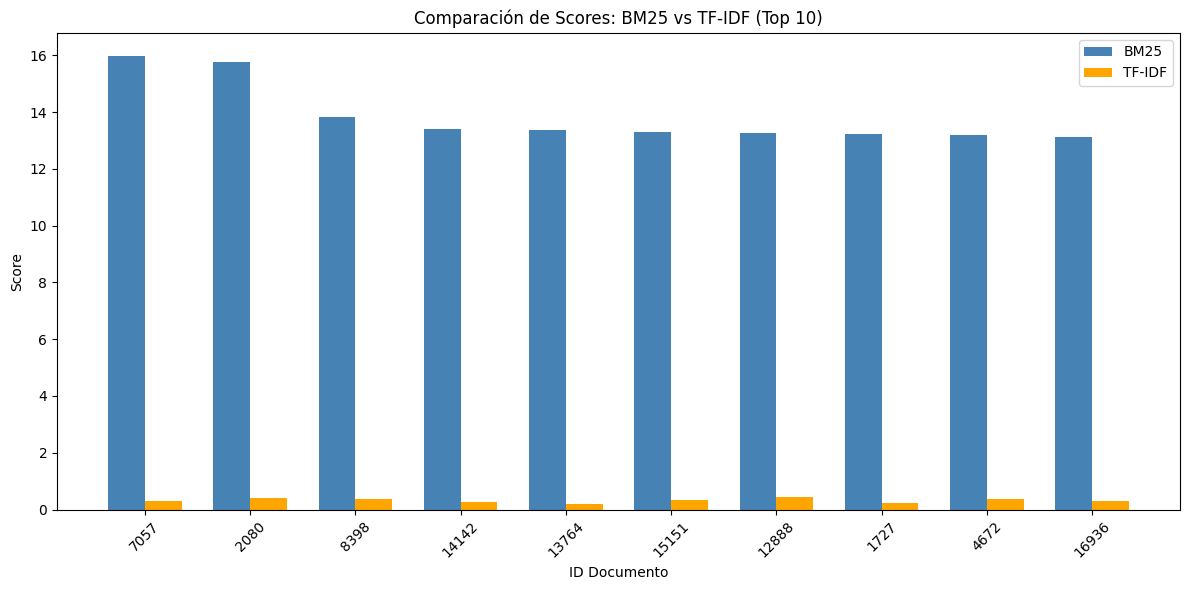


📝 Comparación de documentos top 10 (según BM25):
   Documento  Score BM25  Score TF-IDF Relevante
0       7057   15.989355      0.298103          
1       2080   15.774952      0.393987          
2       8398   13.830863      0.367030          
3      14142   13.402936      0.254314          
4      13764   13.368513      0.206197          
5      15151   13.306665      0.347948          
6      12888   13.246286      0.444718          
7       1727   13.218306      0.217398          
8       4672   13.205103      0.376883          
9      16936   13.127146      0.298001          


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi

# -----------------------------------------------------
# Paso 1: Cargar corpus y definir consulta relevante
# -----------------------------------------------------
# Suponiendo que ya tienes cargado el corpus 'newsgroupsdocs'
# Ejemplo si no lo tienes:
# from sklearn.datasets import fetch_20newsgroups
# newsgroups = fetch_20newsgroups(subset='all')
# newsgroupsdocs = newsgroups.data

# Consulta
consulta = "space shuttle"

# Documentos que consideras relevantes (ajusta según tu conocimiento del corpus)
documentos_relevantes = {40, 123, 135, 420, 987}

# -----------------------------------------------------
# Paso 2: Preprocesamiento para BM25 y TF-IDF
# -----------------------------------------------------
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]

# BM25
bm25 = BM25Okapi(tokenized_corpus)
consulta_bm25 = consulta.lower().split()
bm25_scores = bm25.get_scores(consulta_bm25)
ranking_bm25 = np.argsort(bm25_scores)[::-1]

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(newsgroupsdocs)
consulta_tfidf = tfidf_vectorizer.transform([consulta])
tfidf_scores = cosine_similarity(X_tfidf, consulta_tfidf).flatten()
ranking_tfidf = np.argsort(tfidf_scores)[::-1]

# -----------------------------------------------------
# Paso 3: Funciones de evaluación
# -----------------------------------------------------
def precision_at_k(ranking, relevantes, k):
    ranking_k = ranking[:k]
    aciertos = sum(1 for doc_id in ranking_k if doc_id in relevantes)
    return aciertos / k

def average_precision(ranking, relevantes):
    precisiones = []
    hits = 0
    for i, doc_id in enumerate(ranking):
        if doc_id in relevantes:
            hits += 1
            precisiones.append(hits / (i + 1))
    if hits == 0:
        return 0.0
    return sum(precisiones) / hits

# -----------------------------------------------------
# Paso 4: Cálculo de métricas
# -----------------------------------------------------
precision3_bm25 = precision_at_k(ranking_bm25, documentos_relevantes, 3)
map_bm25 = average_precision(ranking_bm25, documentos_relevantes)

precision3_tfidf = precision_at_k(ranking_tfidf, documentos_relevantes, 3)
map_tfidf = average_precision(ranking_tfidf, documentos_relevantes)

# -----------------------------------------------------
# Paso 5: Resultados y comparación
# -----------------------------------------------------
print("\n📊 Evaluación de modelos para la consulta:", consulta)
print("Documentos relevantes definidos manualmente:", documentos_relevantes)
print(f"🔹 BM25    - Precision@3: {precision3_bm25:.3f}, MAP: {map_bm25:.3f}")
print(f"🔸 TF-IDF  - Precision@3: {precision3_tfidf:.3f}, MAP: {map_tfidf:.3f}")

# -----------------------------------------------------
# Paso 6: Visualización (opcional)
# -----------------------------------------------------
top_n = 10
top_docs = ranking_bm25[:top_n]

comparacion_df = pd.DataFrame({
    'Documento': top_docs,
    'Score BM25': [bm25_scores[i] for i in top_docs],
    'Score TF-IDF': [tfidf_scores[i] for i in top_docs],
    'Relevante': ['✅' if i in documentos_relevantes else '' for i in top_docs]
})

plt.figure(figsize=(12, 6))
x = np.arange(len(comparacion_df))
bar_width = 0.35

plt.bar(x - bar_width/2, comparacion_df['Score BM25'], bar_width, label='BM25', color='steelblue')
plt.bar(x + bar_width/2, comparacion_df['Score TF-IDF'], bar_width, label='TF-IDF', color='orange')

plt.xlabel('ID Documento')
plt.ylabel('Score')
plt.title('Comparación de Scores: BM25 vs TF-IDF (Top 10)')
plt.xticks(x, comparacion_df['Documento'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\n📝 Comparación de documentos top 10 (según BM25):")
print(comparacion_df[['Documento', 'Score BM25', 'Score TF-IDF', 'Relevante']])

